In [ ]:
!pip install torch==2.5.0
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
import networkx as nx
import pandas as pd
from collections import Counter
from itertools import combinations
import ast
from google.colab import drive
import numpy as np
import os

import torch_geometric
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test(model, data):
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc

def train_node2vec_for_cluster(label, cluster_df):
    print(f"Working on Cluster {label}")
    print(f"Building graph")
    G = nx.Graph()

    # Building the graph from the dataframe
    for i, row in cluster_df.iterrows():
        for word in row['intervention_words']:
            if word not in G.nodes:
                G.add_node(word, count=1)
            else:
                G.nodes[word]['count'] += 1

    for i, row in cluster_df.iterrows():
        words = row['intervention_words']
        word_pairs = list(combinations(set(words), 2))

        for w1, w2 in word_pairs:
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1
            else:
                G.add_edge(w1, w2, weight=1)

    data = from_networkx(G)

    # Assign random labels to nodes
    num_nodes = data.num_nodes
    random_labels = torch.randint(0, 2, (num_nodes,))
    data.y = random_labels

    # Create train/test masks
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)

    train_size = int(0.8 * num_nodes)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[indices[:train_size]] = True
    test_mask[indices[train_size:]] = True

    data.train_mask = train_mask
    data.test_mask = test_mask

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Node2Vec(data.edge_index, embedding_dim=64, walk_length=30, context_size=10,
                     walks_per_node=200, num_negative_samples=1, p=1, q=1)

    model = model.to(device)
    loader = model.loader(batch_size=64, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    print("Training Node2Vec model...")
    for epoch in range(1, 51):
        loss = train(model, loader, optimizer, device)
        acc = test(model, data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

    # Save the model
    model_path = f"/content/drive/MyDrive/thesis/data/cluster_{label}_n2v.model"
    torch.save(model.state_dict(), model_path)

    print(f"Saved model for Cluster {label}")

In [4]:
full_df = pd.read_csv(r"/content/drive/MyDrive/full_df.csv", index_col=0)
full_df.head()

,session_id,date,chamber,intervention_id,intervention_text,intervention_words,embeddings,cluster,num_words,year,svd_embeddings,graph_embeddings
0,gaceta_459 (7),2006-10-18,senate,452004,(julio 21) por medio de la cual se crea una c...,"['accidental', 'acreditación', 'acrediten', 'a...",[ 2.75705218e-01 -1.56717077e-01 5.24776168e-...,5,21,2006,[-1.07373972e+01 -5.24858566e-02 -3.47477753e-...,[-10.73739721 -0.05248475]
1,gaceta_459 (7),2006-10-18,senate,452003,(septiembre 11) por medio de la cual se aclar...,"['aclara', 'aclárese', 'acto', 'administrativo...",[ 4.02346551e-01 -1.51027605e-01 2.49001503e-...,1,26,2006,[-1.11914571e+01 1.63042020e+00 1.67238361e+...,[-11.19145712 1.63042081]
2,gaceta_459 (7),2006-10-18,senate,452002,(septiembre 8) por medio de la cual se design...,"['artículo', 'comisión', 'congreso', 'convenio...",[ 1.86938807e-01 -1.24048591e-01 4.23117690e-...,5,16,2006,[-1.12215688e+01 -2.87521366e-01 -6.22032624e-...,[-11.22156882 -0.2875204 ]
3,gaceta_459 (7),2006-10-18,senate,452001,si bien el crecimiento económico es un factor ...,"['aumentado', 'crecimiento', 'distribución', '...",[ 5.93414120e-02 -1.13201797e-01 1.75440997e-...,5,21,2006,[-1.10547869e+01 -2.22703892e+00 -2.72106466e+...,[-11.05478689 -2.22703888]
4,gaceta_459 (7),2006-10-18,senate,451999,fuente: merpd la disminución en la inequidad ...,"['aquellos', 'aumentado', 'caído', 'coeficient...",[ 4.15660948e-01 -1.86677556e-02 3.19064856e-...,2,33,2006,[-1.08555325e+01 -1.99172156e+00 -1.98372695e+...,[-10.85553251 -1.99172263]


In [5]:
full_df['intervention_words'] = full_df['intervention_words'].apply(ast.literal_eval)

useful_clusters = [1, 2, 3, 6, 7, 9]
clusters_dfs = {cluster: full_df[full_df['cluster'] == cluster] for cluster in useful_clusters}

In [ ]:
for label in useful_clusters:
    train_node2vec_for_cluster(label, clusters_dfs[label])

## Analyzing models

In [6]:
Data_dict = {}
for label in useful_clusters:
    G = nx.Graph()
    cluster_df = clusters_dfs[label]
    # Building the graph from the dataframe
    for i, row in cluster_df.iterrows():
        for word in row['intervention_words']:
            if word not in G.nodes:
                G.add_node(word, count=1)
            else:
                G.nodes[word]['count'] += 1

    for i, row in cluster_df.iterrows():
        words = row['intervention_words']
        word_pairs = list(combinations(set(words), 2))

        for w1, w2 in word_pairs:
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1
            else:
                G.add_edge(w1, w2, weight=1)

    # Convert the graph to a PyTorch Geometric Data object
    Data_dict[label] = from_networkx(G)

In [7]:
models_folder = '/content/drive/MyDrive/thesis/data'
model_paths = [os.path.join(models_folder, file) for file in os.listdir(models_folder) if file.endswith('.model')]

models_dict = {}

for model_path in model_paths:
    print(f"Loading model: {model_path}")

    data = Data_dict[int(model_path.split('_')[1])]

    # Load the model
    model = Node2Vec(data.edge_index, embedding_dim=64, walk_length=30, context_size=10,
                     walks_per_node=200, num_negative_samples=1, p=1, q=1)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Store the model in the dictionary
    models_dict[model_path] = model

print(f"Loaded {len(models_dict)} models.")

Loading model: /content/drive/MyDrive/thesis/data/cluster_1_n2v.model


<ipython-input-7-93e69de2f68d>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading model: /content/drive/MyDrive/thesis/data/cluster_2_n2v.model
Loading model: /content/drive/MyDrive/thesis/data/cluster_3_n2v.model
Loading model: /content/drive/MyDrive/thesis/data/cluster_6_n2v.model
Loading model: /content/drive/MyDrive/thesis/data/cluster_7_n2v.model
Loading model: /content/drive/MyDrive/thesis/data/cluster_9_n2v.model
Loaded 6 models.


In [8]:
avg_similarities = {}
variances = {}

for model_path, model in models_dict.items():
    label = int(model_path.split('_')[1])
    data = Data_dict[label]
    z = model().detach().cpu().numpy()

    cosine_sim_matrix = cosine_similarity(z)
    similarity_variance = np.var(cosine_sim_matrix)

    # Calculate average cosine similarity
    avg_similarity = np.mean(cosine_sim_matrix)
    similarity_variance = np.var(cosine_sim_matrix)

    avg_similarities[label] = avg_similarity
    variances[label] = similarity_variance

    print(f"Avg Cosine Similarity for {label}: {avg_similarity:.4f}")
    print(f"Variance for {label}: {similarity_variance:.4f}")


Avg Cosine Similarity for 1: 0.0195
Variance for 1: 0.0451
Avg Cosine Similarity for 2: 0.0190
Variance for 2: 0.0313
Avg Cosine Similarity for 3: 0.0174
Variance for 3: 0.0433
Avg Cosine Similarity for 6: 0.0220
Variance for 6: 0.0421
Avg Cosine Similarity for 7: 0.0186
Variance for 7: 0.0393
Avg Cosine Similarity for 9: 0.0207
Variance for 9: 0.0312


In [32]:
cluster_names = {
    1: "Sovereignty",
    2: "Executive efficiency",
    3: "Political Sagacity",
    6: "Congress",
    7: "Social Justice",
    9: "Health"
}

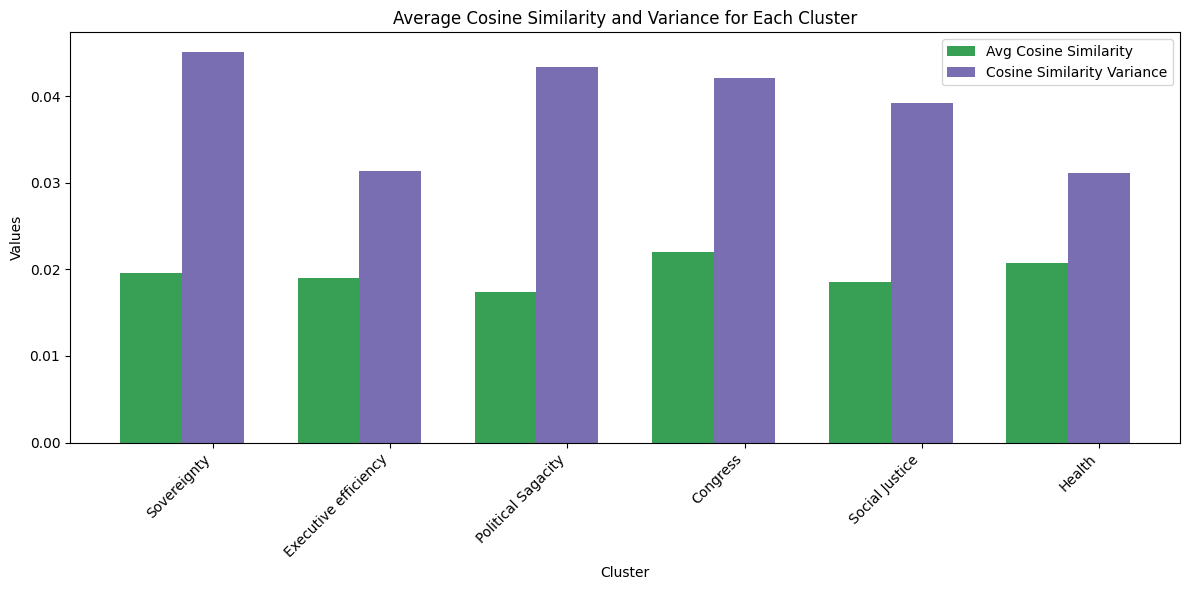

In [35]:
labels = list(cluster_names.values())
avg_values = list(avg_similarities.values())
var_values = list(variances.values())

x = np.arange(len(labels))
width = 0.35

sns.set_palette("muted")
colors = sns.color_palette("Greens", 2)
colors2 = sns.color_palette("Purples", 2)

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width, avg_values, width, label='Avg Cosine Similarity', color=colors[1])
bars2 = ax.bar(x, var_values, width, label='Cosine Similarity Variance', color=colors2[1])

ax.set_xlabel('Cluster')
ax.set_ylabel('Values')
ax.set_title('Average Cosine Similarity and Variance for Each Cluster')
ax.set_xticks(x)
ax.set_xticklabels(cluster_names.values(), rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [16]:
avg_vectors = {}

for model_path, model in models_dict.items():
    z = model().detach().cpu().numpy()
    avg_vector = np.mean(z, axis=0)
    avg_vectors[model_path] = avg_vector


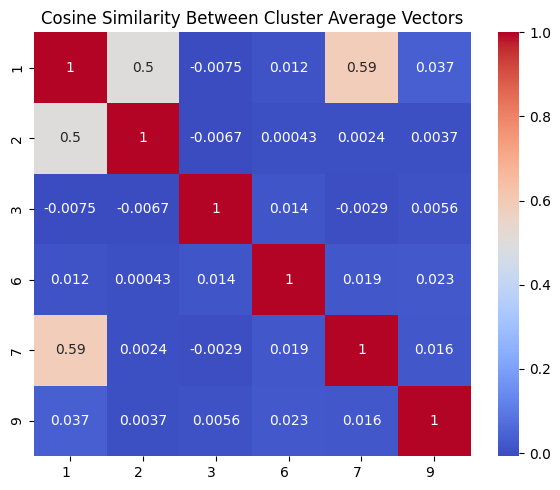

In [38]:
avg_vector_matrix = np.array(list(avg_vectors.values()))
similarity_matrix = cosine_similarity(avg_vector_matrix)

labels = [key.split('_')[1] for key in list(avg_vectors.keys())]

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Cosine Similarity Between Cluster Average Vectors')
plt.xticks(ha='right')
plt.yticks(ha='right')
plt.tight_layout()
plt.show()
